In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import optuna, warnings, random
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, r2_score

plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [67]:
df = pd.read_csv("C:\\Users\\jaygo\\OneDrive\\Desktop\\DAV-project\\dataset\\new dataset\\AIDS_Classification.csv")
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [68]:
# Inspect the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

In [69]:
print(f"Total number of duplicate rows: {df.duplicated().sum()}")
print(f"Total number of missing values: {df.isnull().sum().sum()}")

Total number of duplicate rows: 0
Total number of missing values: 0


In [70]:
grouped_infect = df.groupby("infected")["infected"].count().reset_index(name="counts")

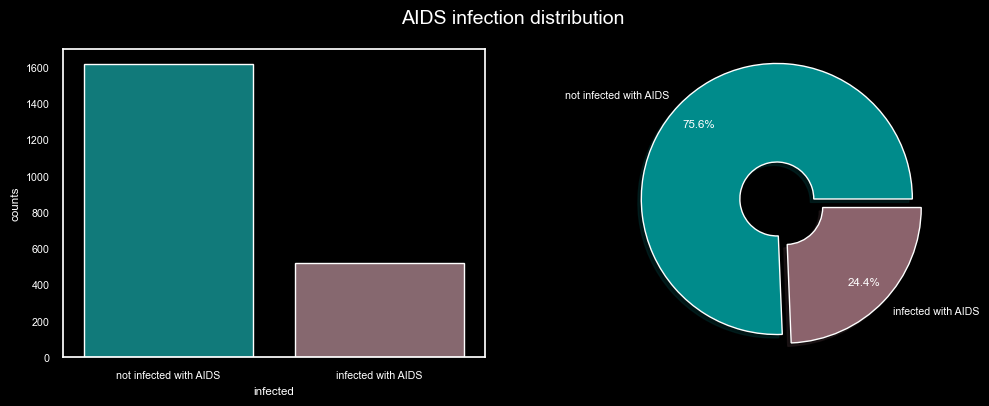

In [71]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x=grouped_infect.infected, y=grouped_infect.counts, palette=["#008b8b", "#8b636c"])
plt.xticks(ticks=(0,1), labels=["not infected with AIDS", "infected with AIDS"])
plt.subplot(1,2,2)
plt.pie(x=grouped_infect.counts, shadow=True, autopct="%.1f%%", pctdistance=0.8,
        labels=["not infected with AIDS", "infected with AIDS"], colors=["#008b8b", "#8b636c"],
        radius=1.4-0.3, wedgeprops=dict(width=0.8), explode= [0.05,0.05])
plt.suptitle("AIDS infection distribution", fontsize=14)
plt.show()

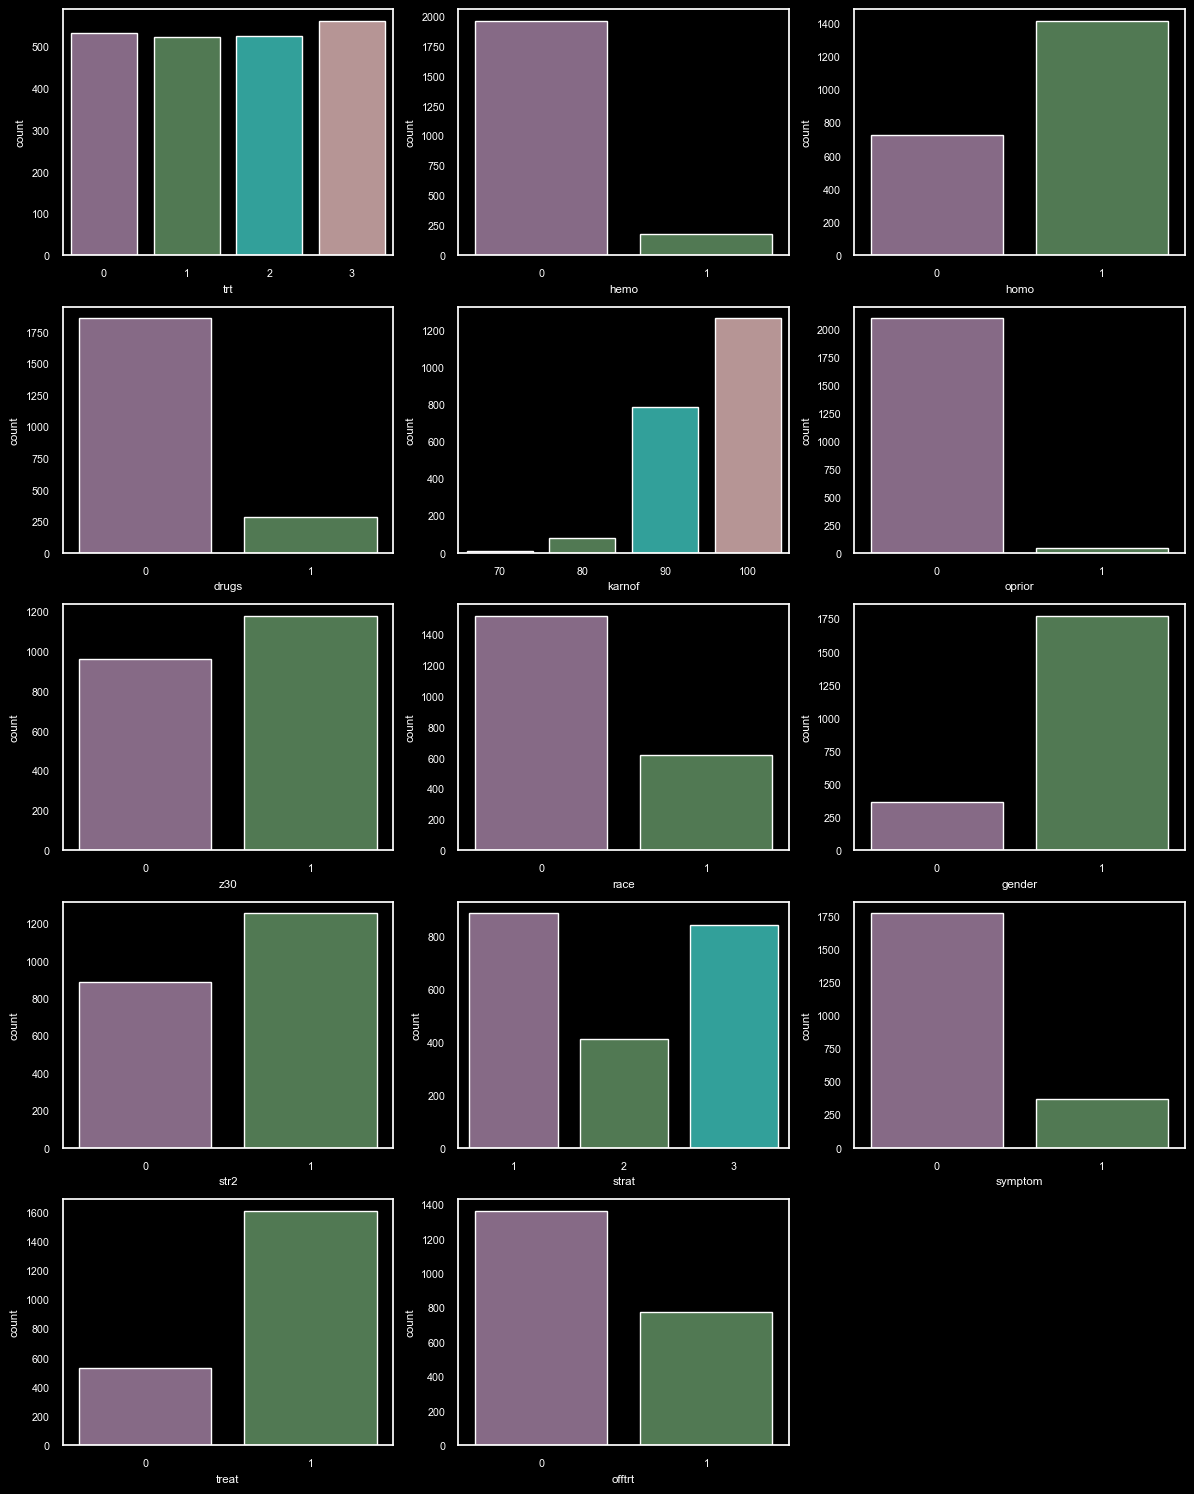

In [72]:

cat_cols = ["trt", "hemo", "homo", "drugs", "karnof", "oprior", "z30",
            "race", "gender", "str2", "strat", "symptom", "treat", "offtrt"]
clr = ["#8b658b", "#4a804d", "#20b2aa", "#bc8f8f", "#6495ed"]
plt.figure(figsize=(12,15))

for i, col in enumerate(cat_cols):
    plt.subplot(5,3, i+1)
    sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(), palette=clr)
plt.tight_layout()
plt.show()

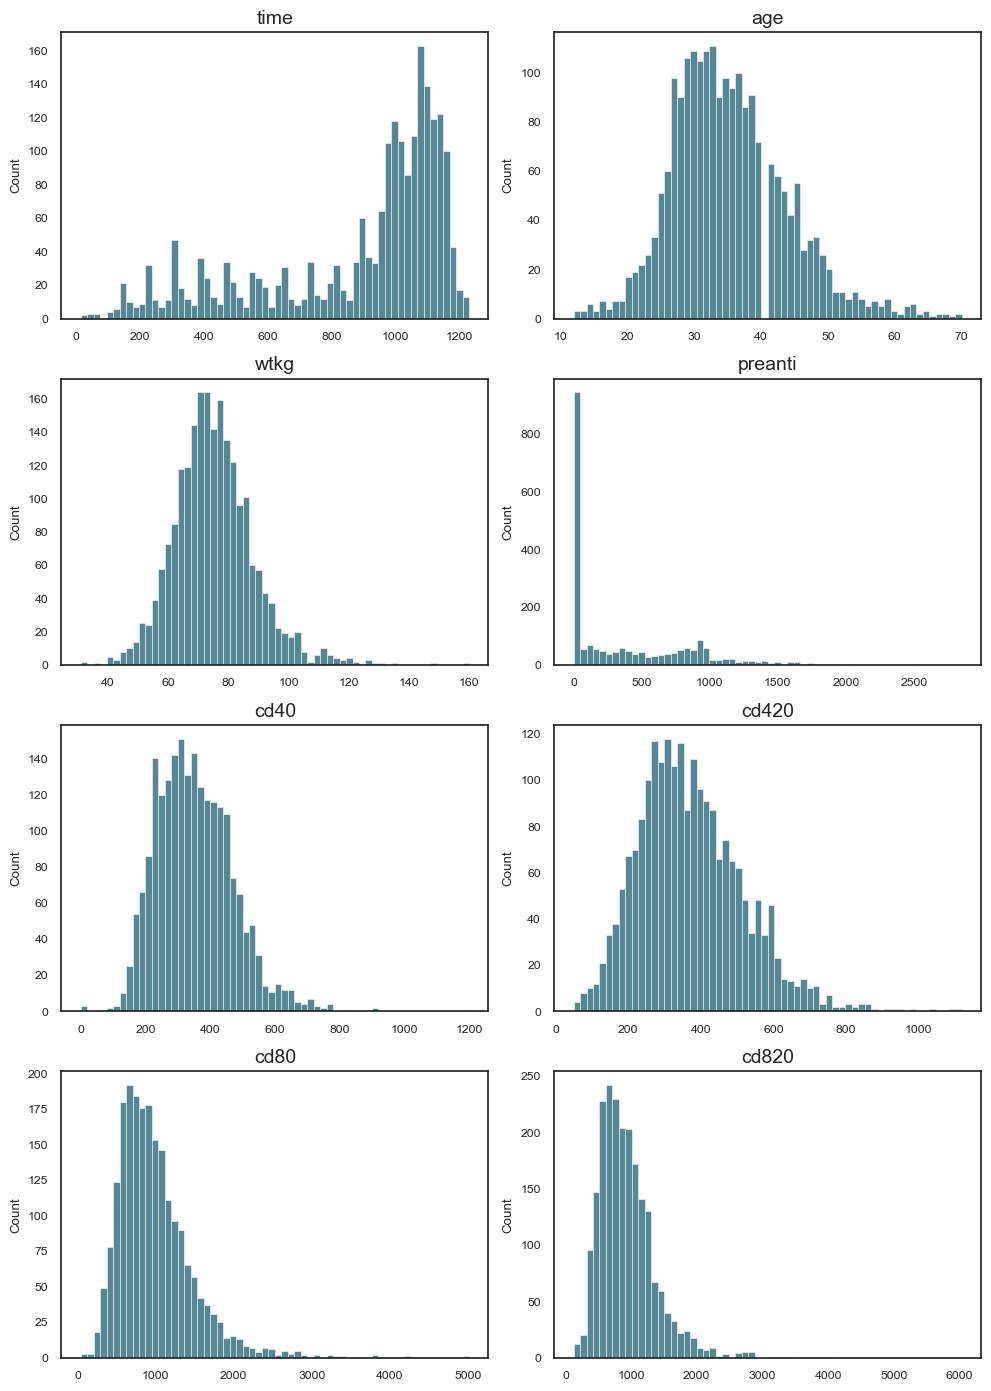

In [73]:

num_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

sns.set(font_scale=0.8)
sns.set_style("white")
plt.figure(figsize=(10,14))
for i, col in enumerate(num_cols):
    plt.subplot(4,2, i+1)
    sns.histplot(df[col], bins=60, color="#1c6071")
    plt.xlabel("")
    plt.title(col, fontsize=14)
plt.tight_layout()
plt.show()

In [74]:
df = df[['infected', 'time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80',
         'cd820', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender',
         'str2', 'symptom', 'treat', 'offtrt', 'trt', 'karnof','strat']]

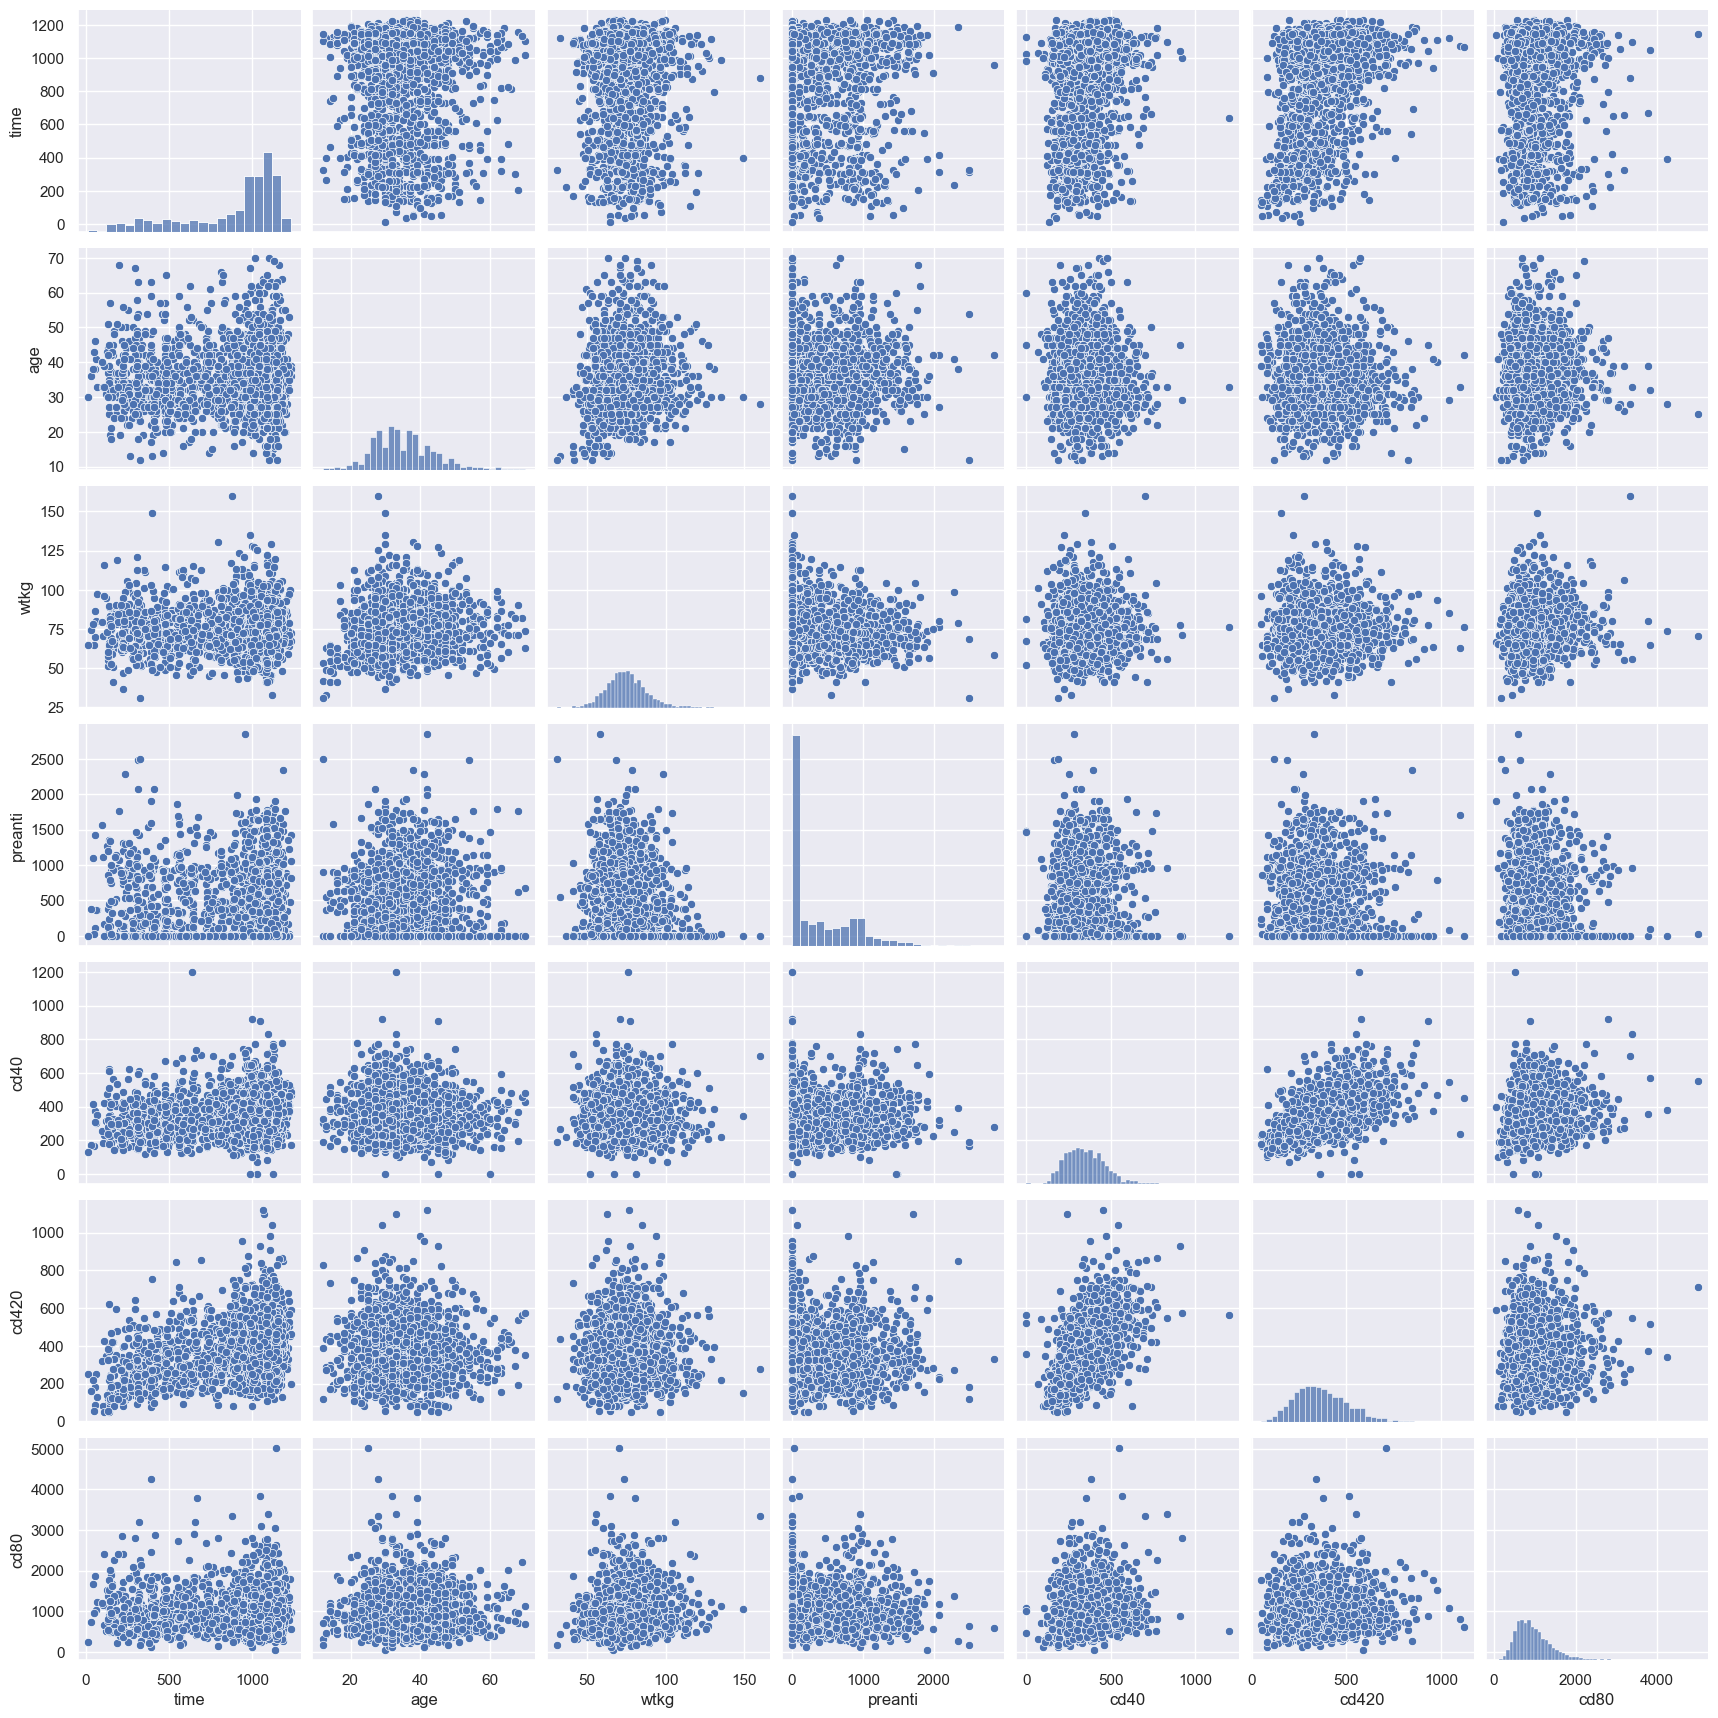

In [75]:
sns.set(font_scale=1)
sns.pairplot(df.iloc[:, 1:8])
plt.show()

In [76]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'ubuntu'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

In [77]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
infected,2139.000000,0.243572,0.429338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
time,2139.000000,879.098177,292.274324,14.000000,14.000000,727.000000,825.000000,997.000000,1091.000000,1105.000000,1231.000000,1231.000000
age,2139.000000,35.248247,8.709026,12.000000,12.000000,29.000000,30.000000,34.000000,40.000000,42.000000,70.000000,70.000000
wtkg,2139.000000,75.125311,13.263164,31.000000,31.000000,66.679200,68.200000,74.390400,82.555200,84.809280,159.939360,159.939360
preanti,2139.000000,379.175783,468.657526,0.000000,0.000000,0.000000,0.000000,142.000000,739.500000,842.000000,2851.000000,2851.000000
cd40,2139.000000,350.501169,118.573863,0.000000,0.000000,263.500000,280.000000,340.000000,423.000000,444.400000,1199.000000,1199.000000
cd420,2139.000000,371.307153,144.634909,49.000000,49.000000,269.000000,285.000000,353.000000,460.000000,486.000000,1119.000000,1119.000000
cd80,2139.000000,986.627396,480.197750,40.000000,40.000000,654.000000,700.000000,893.000000,1207.000000,1305.000000,5011.000000,5011.000000
cd820,2139.000000,935.369799,444.976051,124.000000,124.000000,631.500000,678.000000,865.000000,1146.500000,1223.000000,6035.000000,6035.000000
hemo,2139.000000,0.084151,0.277680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [78]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.


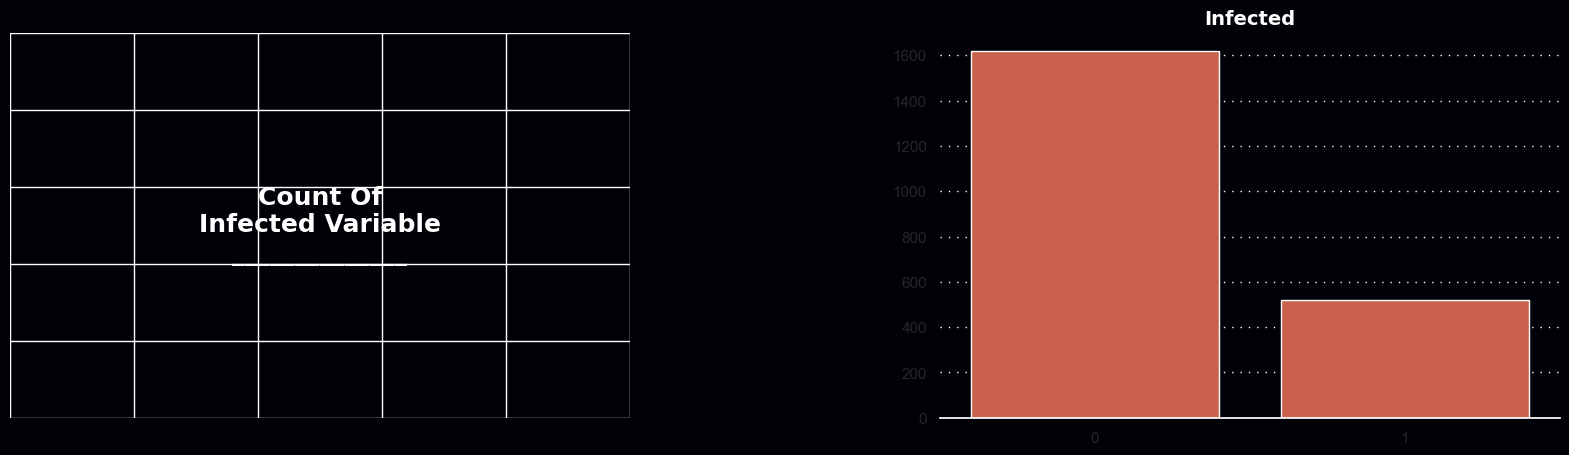

In [79]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nInfected Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

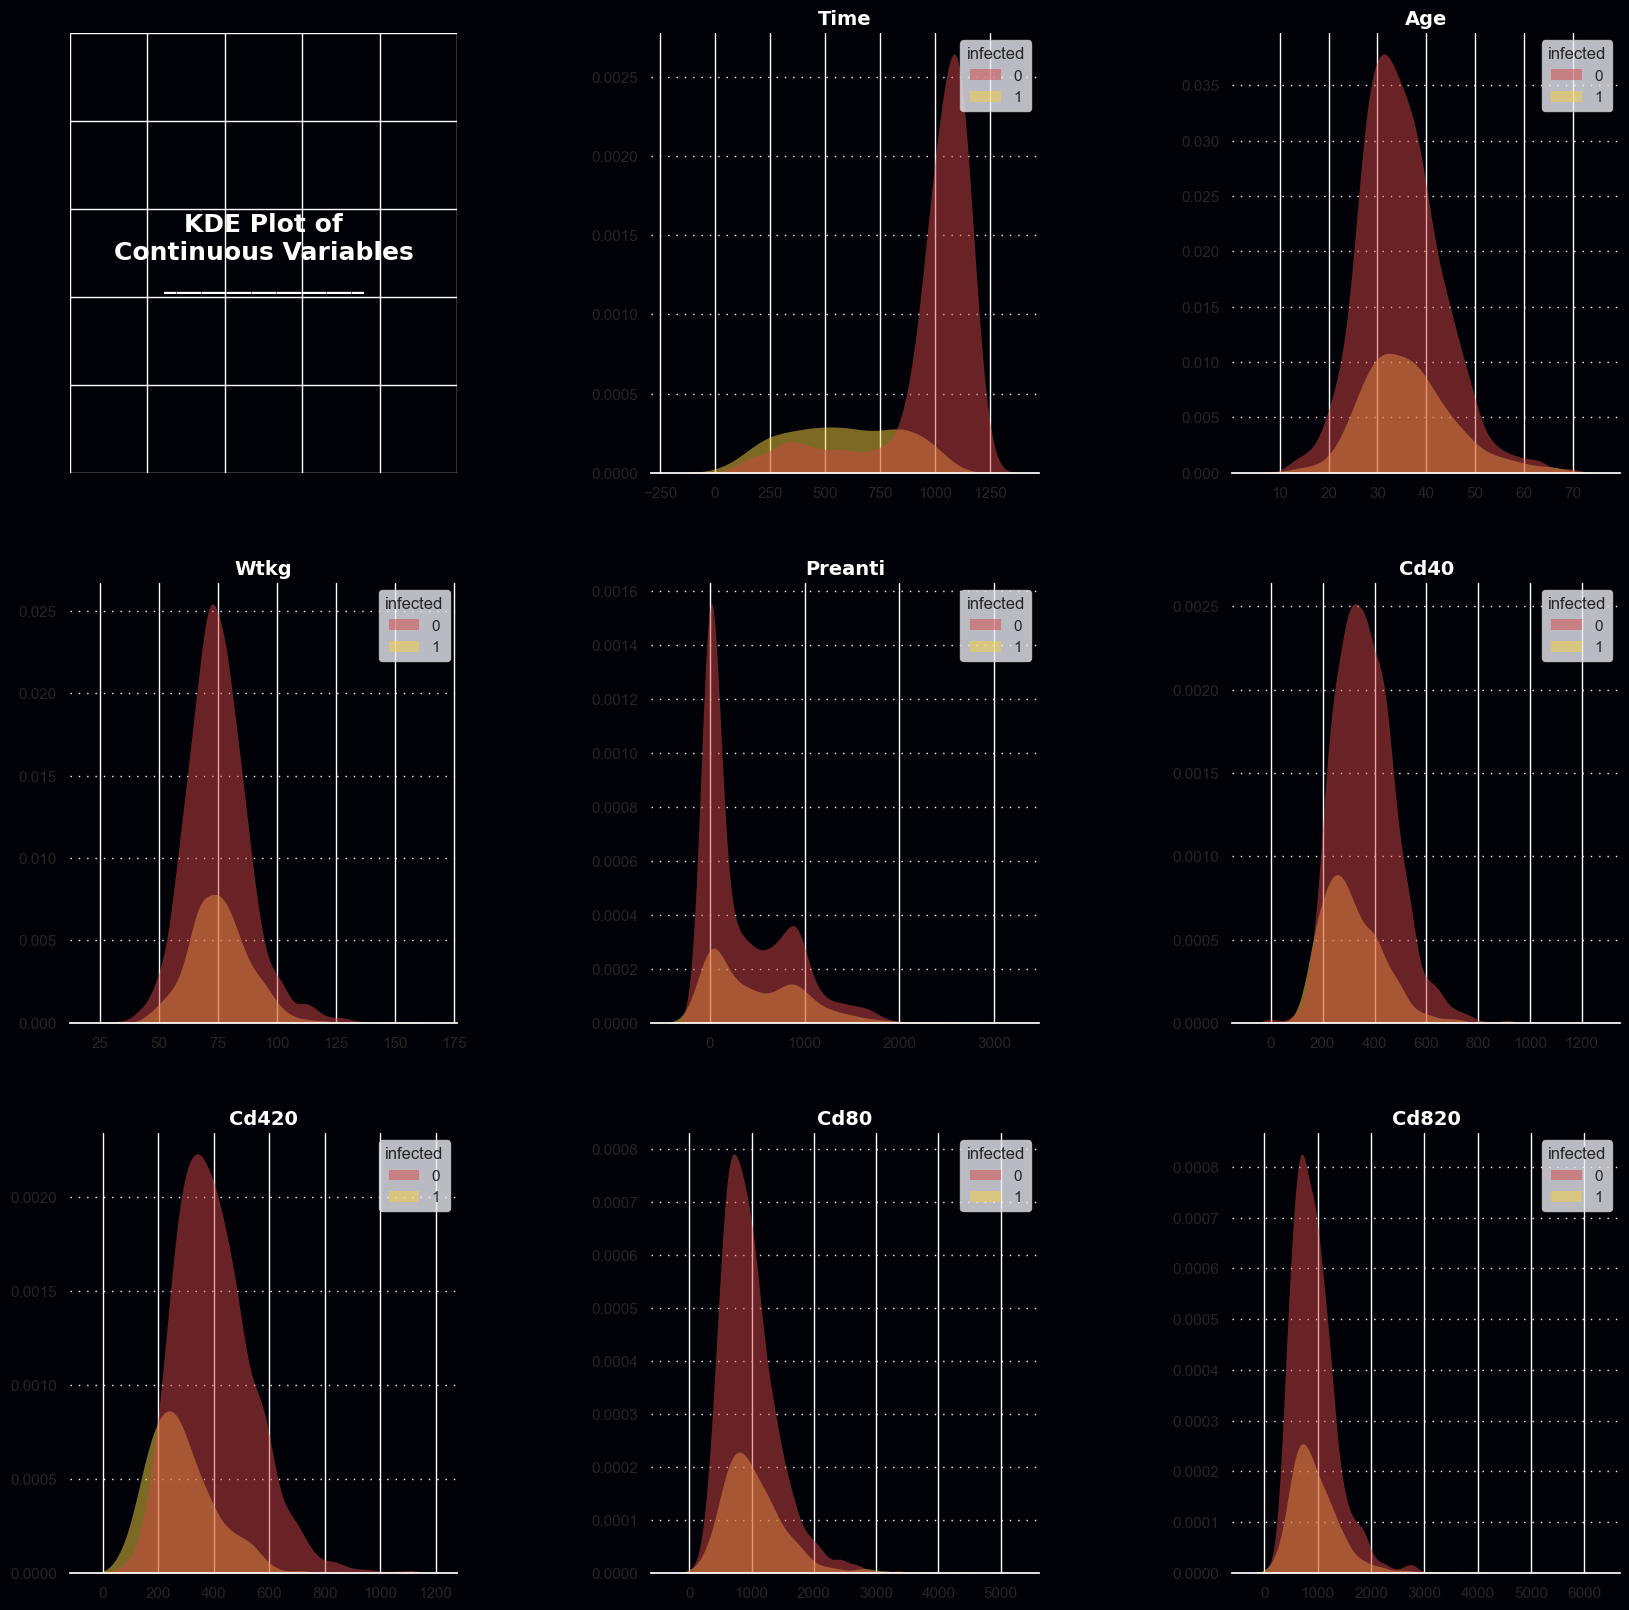

In [80]:
axes, palette, cb = mPlotter(3, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[1:3], alpha=.5, linewidth=0, fill=True)
    cb(ax)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

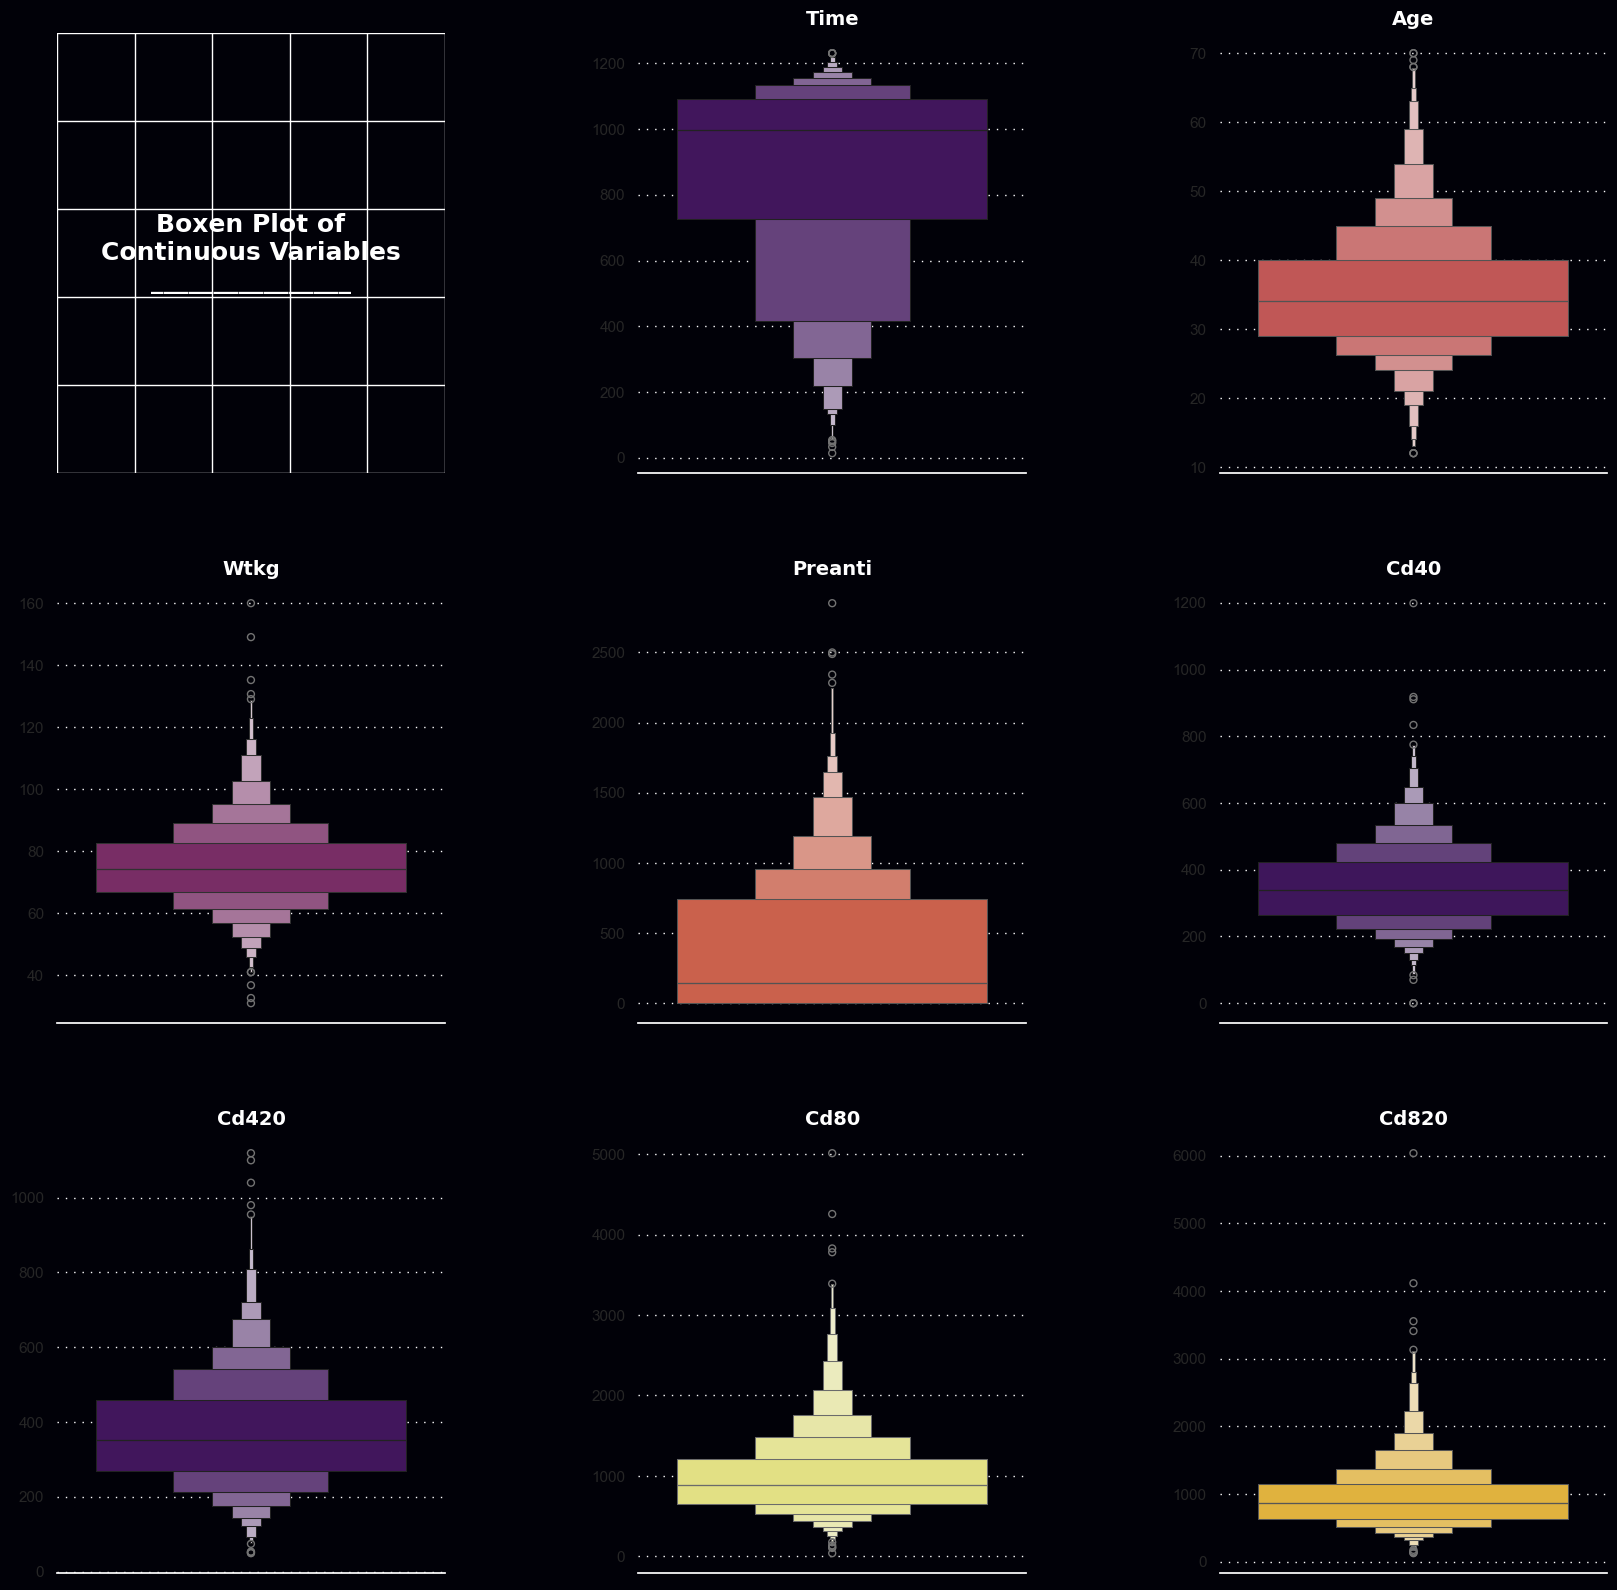

In [81]:
axes, palette, cb = mPlotter(3, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, y=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not found.
findfont: Font family 'ubuntu' not

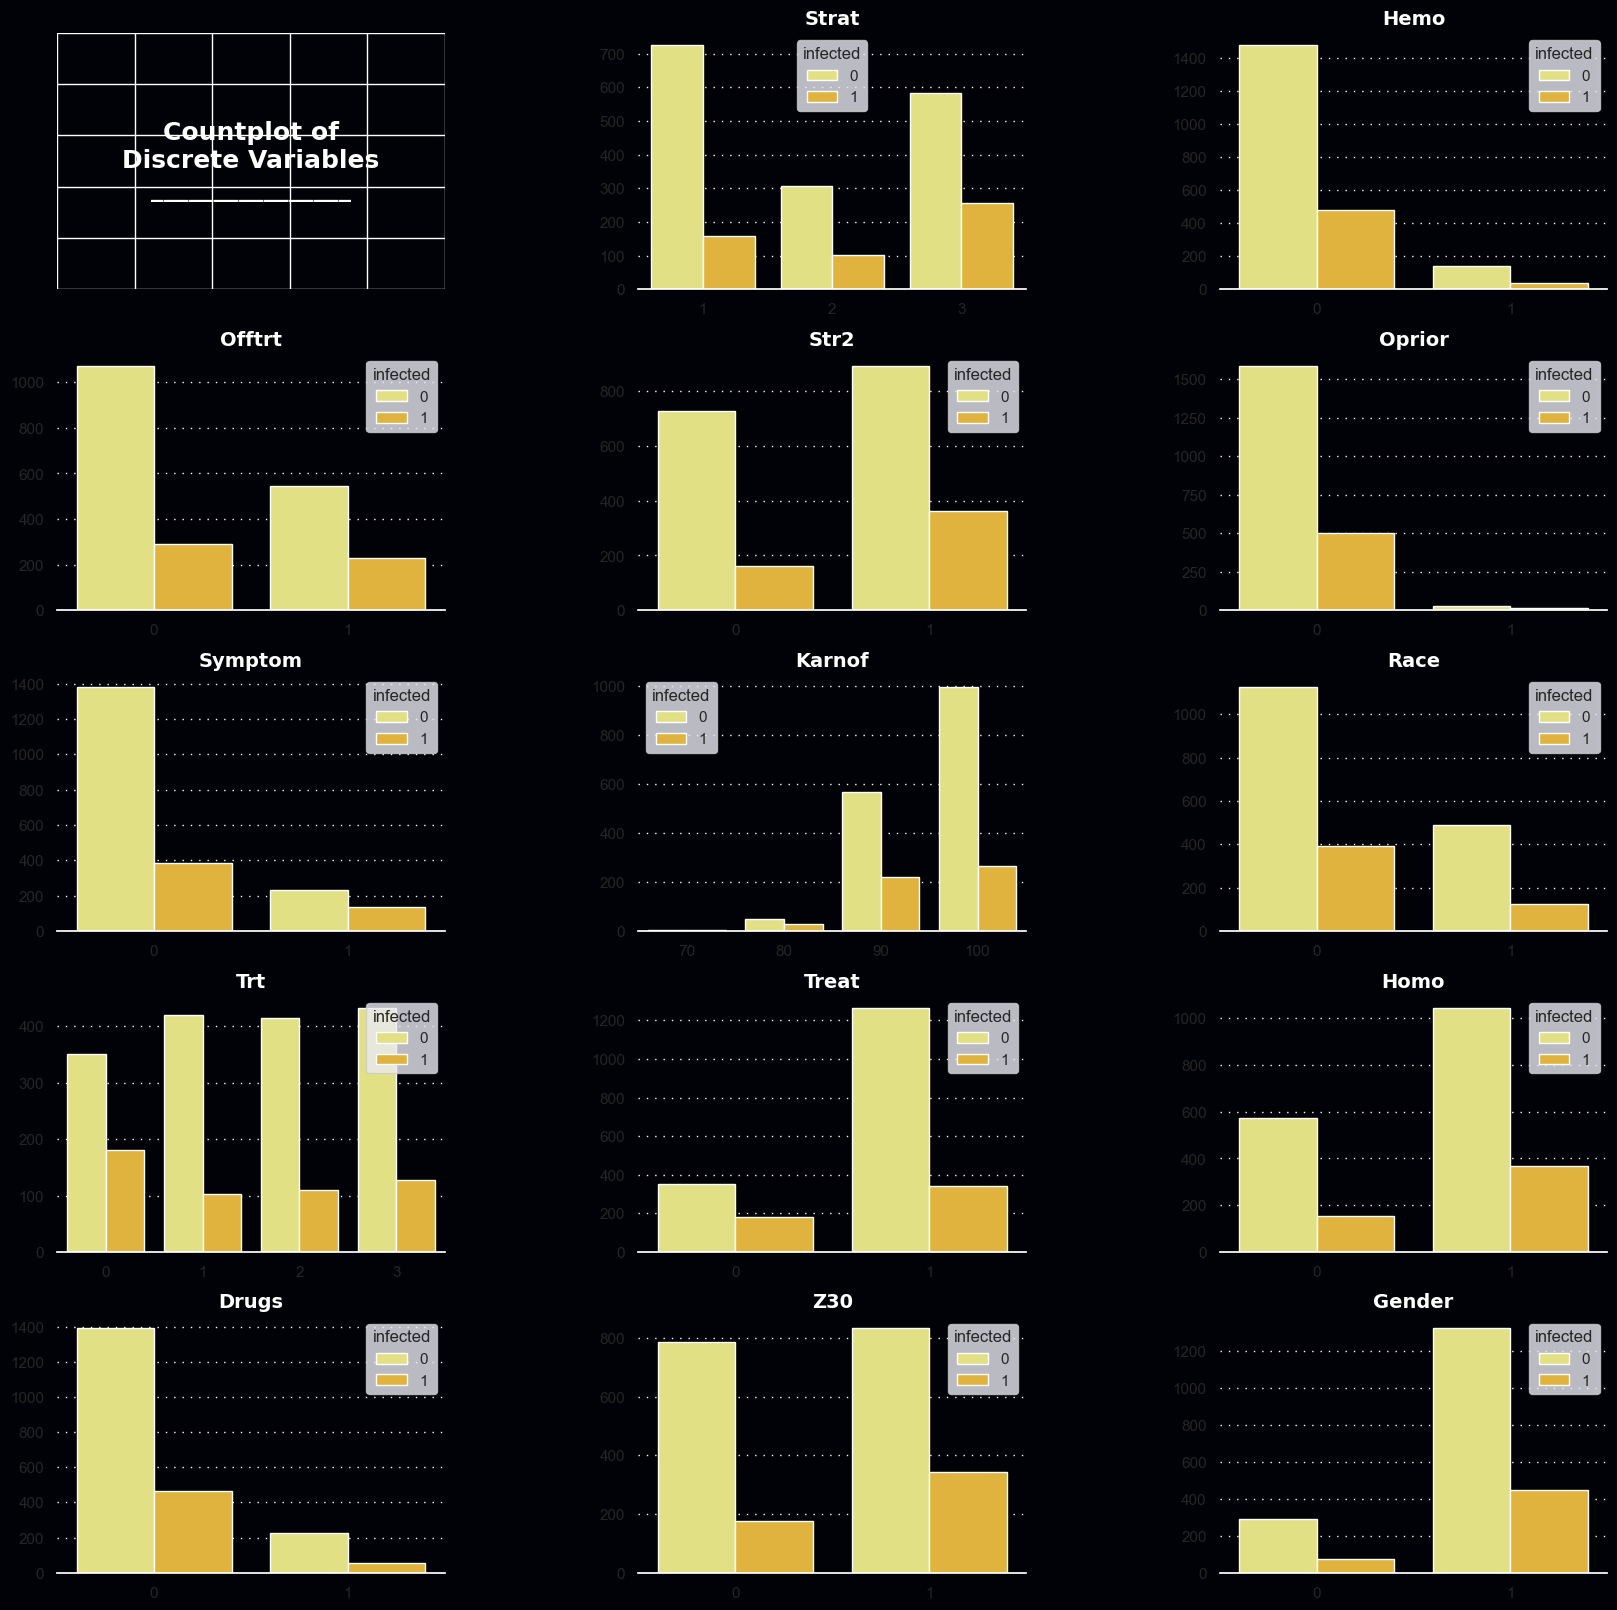

In [82]:
axes, palette, cb = mPlotter(5, 3, (20, 20), dis_cols, 'Countplot of\nDiscrete Variables\n________________')

for col, ax in zip(dis_cols, axes[1:]):
    sns.countplot(x=df[col], ax = ax, hue=df[target], palette=palette[6:8])
    cb(ax)

In [83]:
infect_corr = df.corr()["infected"].drop("infected", axis=0)
infect_corr = infect_corr.sort_values(ascending=False)

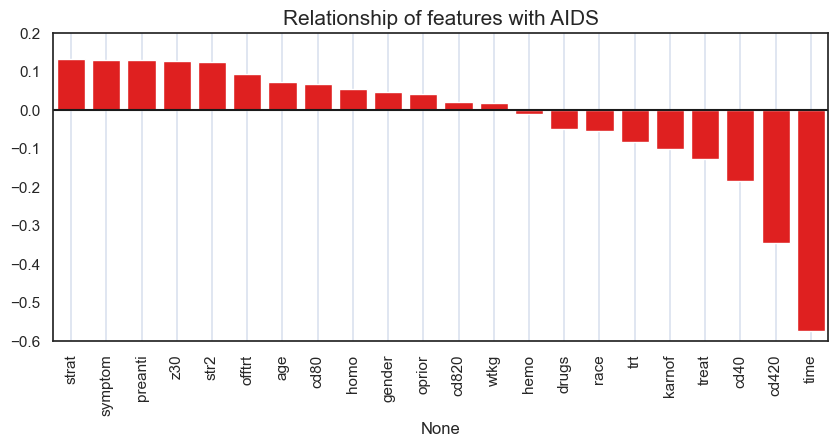

In [84]:

sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=infect_corr.values, x=infect_corr.index, color="red")
plt.axhline(0, color="k")
plt.xticks(rotation=90)
plt.grid(visible=True, axis="x", color="b", lw=0.25)
plt.ylim(-0.6, 0.2)
plt.title("Relationship of features with AIDS", fontsize=15)
plt.show()

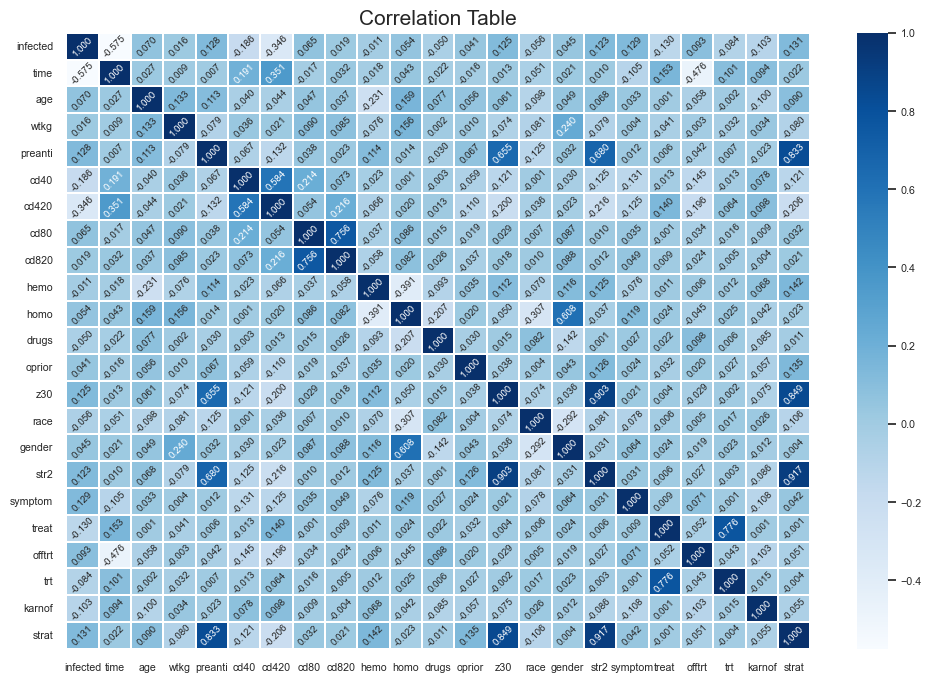

In [85]:

plt.figure(figsize=(12,8))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(), annot=True, annot_kws={"rotation":45, "fontsize":7}, fmt=".3f", linewidths=0.1, cmap="Blues")
plt.title("Correlation Table", fontsize=15)
plt.show()

In [86]:
data = df.copy()
data = pd.get_dummies(data=data, columns=["trt", "karnof", "strat"])

In [87]:
scaler = StandardScaler()
data.iloc[:, 1:9] = scaler.fit_transform(data.iloc[:, 1:9])

In [88]:
y = data["infected"]
X = data.drop("infected", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=42)

In [89]:
model_list = [LogisticRegression(), GradientBoostingClassifier(), MLPClassifier(max_iter=1000),
              AdaBoostClassifier(), HistGradientBoostingClassifier(), SVC(), XGBClassifier(),
              CatBoostClassifier(verbose=False)]

model_name_list = []
accuracy_list = []

for model_name in model_list: 
    
    model = model_name
    model_cv = cross_val_score(model,
                               X,
                               y,
                               cv=10,
                               scoring= "accuracy", 
                               n_jobs=-1)
    
    model_name_list.append(model_name.__class__.__name__)
    accuracy_list.append(model_cv.mean())
    
    print(f"{model_name.__class__.__name__} cross validation score: {model_cv.mean()}")
    print("-" * 50)

LogisticRegression cross validation score: 0.8657869334386381
--------------------------------------------------
GradientBoostingClassifier cross validation score: 0.8943310956079153
--------------------------------------------------
MLPClassifier cross validation score: 0.8611250054846211
--------------------------------------------------
AdaBoostClassifier cross validation score: 0.881233820367689
--------------------------------------------------
HistGradientBoostingClassifier cross validation score: 0.884513623798868
--------------------------------------------------
SVC cross validation score: 0.8845004607081742
--------------------------------------------------
XGBClassifier cross validation score: 0.8882519415558772
--------------------------------------------------
CatBoostClassifier cross validation score: 0.8938638058882894
--------------------------------------------------


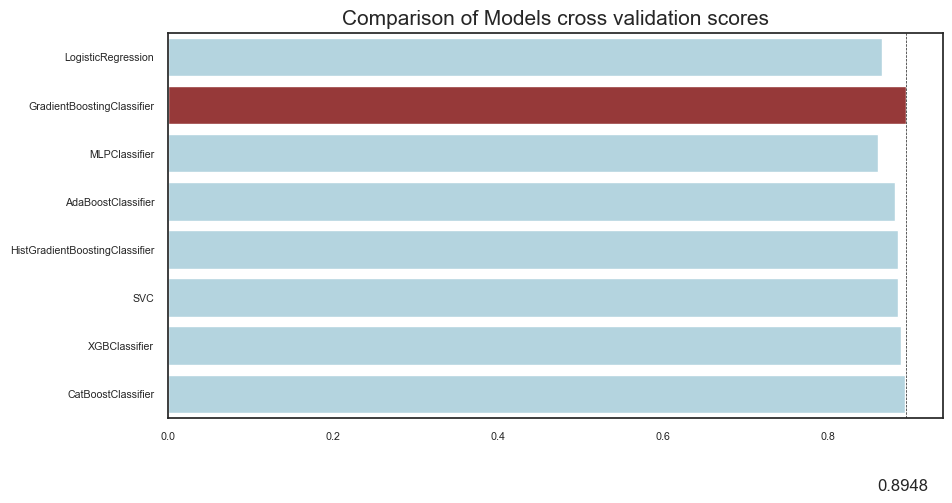

In [90]:
sns.set_style("white")
plt.figure(figsize=(10,5))
clrs = ["brown" if i == max(accuracy_list) else "lightblue" for i in accuracy_list]
sns.barplot(x=accuracy_list, y=model_name_list, palette=clrs)
plt.axvline(0.8948, ls="--", lw=0.5, color="k")
plt.text(0.86,9, s="0.8948", fontsize=12)
plt.title("Comparison of Models cross validation scores", fontsize=15)
plt.show()

In [91]:
cat_boost = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
data_feature_importance = pd.DataFrame(cat_boost.feature_importances_, columns=["feature_importance"])
data_feature_importance["features"] = data.columns[1:]
data_feature_importance = data_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)

In [92]:
data_feature_importance.head()

,feature_importance,features
0,38.948878,time
1,9.192205,cd420
2,8.730946,offtrt
3,6.128697,wtkg
4,4.814286,cd40


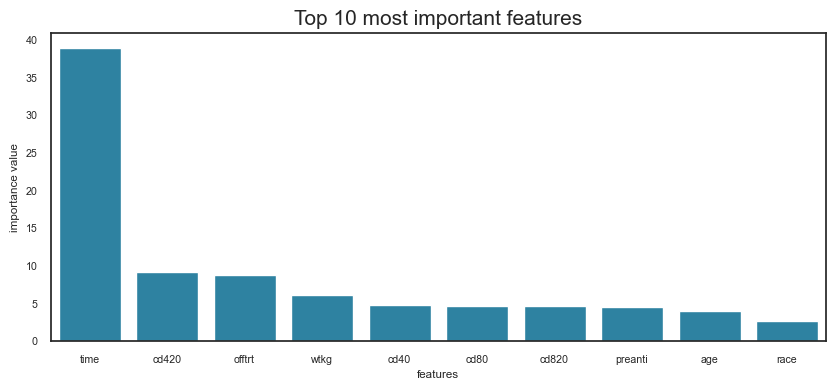

In [93]:
sns.set_style("white")
plt.figure(figsize=(10,4))
sns.barplot(y=data_feature_importance.feature_importance[:10],
            x=data_feature_importance.features[:10], color="#1b8bb4")
plt.ylabel("importance value")
plt.title("Top 10 most important features", fontsize=15)
plt.show()

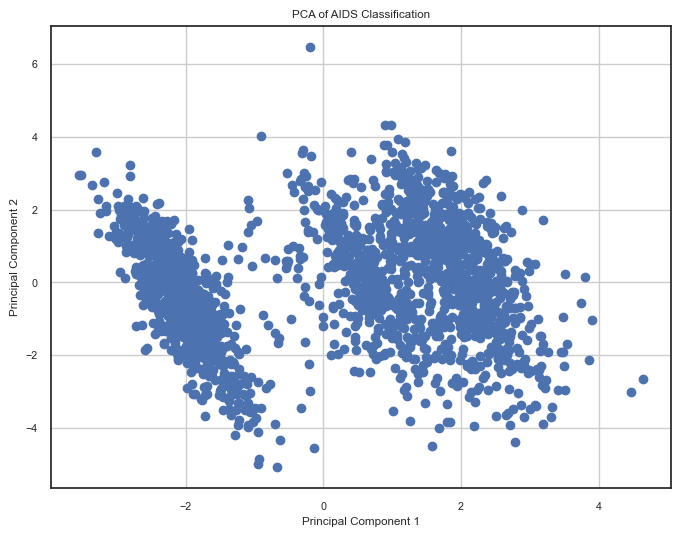

In [94]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))  # Only numeric columns

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(df_scaled)

# Creating a DataFrame for the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Plotting the results
plt.figure(figsize=(8,6))
plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of AIDS Classification')
plt.grid(True)
plt.show()

In [95]:
print("We will preform multiple regression analysis to see how 'gender', 'race', ")
print("and 'wtkg - weight to 'age'")

import statsmodels.api as sm

# Define the dependent variable (y) and independent variables (X)
y = df['age']
X = df[['drugs', 'gender', 'race', 'wtkg']]

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the regression model
model = sm.OLS(y, X).fit()

# Printing the summary of the regression model
print(model.summary())

We will preform multiple regression analysis to see how 'gender', 'race', 
and 'wtkg - weight to 'age'
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     17.88
Date:                Sun, 05 May 2024   Prob (F-statistic):           1.90e-14
Time:                        16:15:19   Log-Likelihood:                -7628.9
No. Observations:                2139   AIC:                         1.527e+04
Df Residuals:                    2134   BIC:                         1.530e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

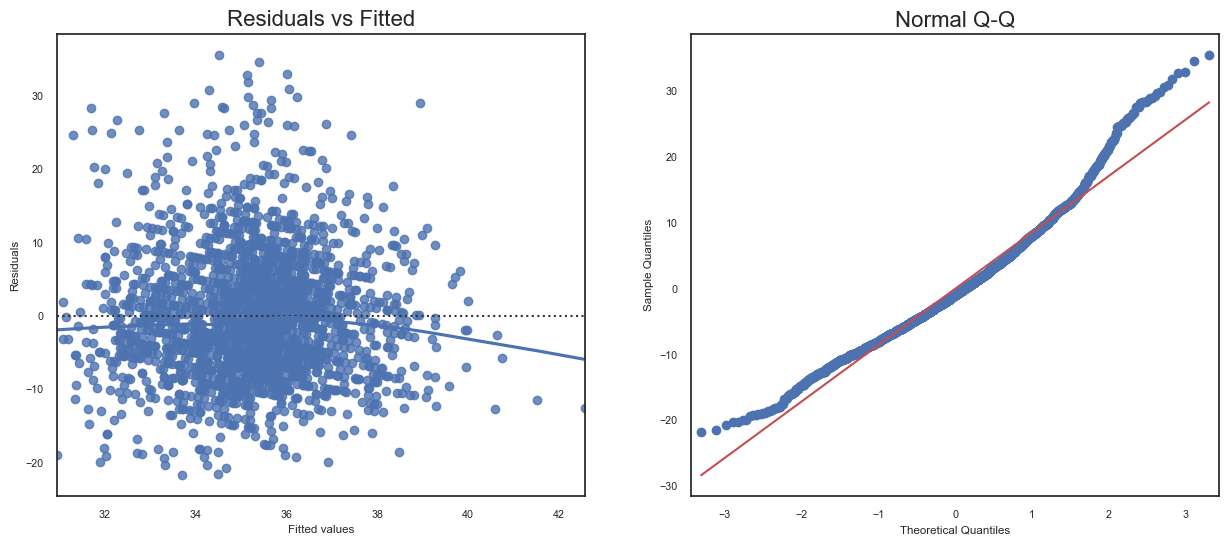

In [96]:
# Plotting residuals to check for homoscedasticity and independence (Checking Assumptions)
residuals = model.resid
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, ax=ax[0])
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')

# Normal QQ plot for checking normality of residuals
sm.qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Normal Q-Q', fontsize=16)
plt.show()

In [97]:
from factor_analyzer import FactorAnalyzer

# Initialize and fit the factor analysis model
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df.select_dtypes(include=[np.number]))

# Check the loadings (correlation coefficient between variables and factor)
loadings = fa.loadings_
print(loadings)

# Get eigenvalues for the factor scores
ev, v = fa.get_eigenvalues()
print(ev)

[[ 0.10426214 -0.56013036  0.08173039]
 [ 0.06322062  0.70632891  0.06774575]
 [ 0.08228158 -0.04048373  0.20272076]
 [-0.08866328 -0.00859658  0.25408858]
 [ 0.77018052 -0.02998022  0.06516607]
 [-0.11380143  0.45402254  0.04568131]
 [-0.18689131  0.65419042  0.06880273]
 [ 0.0311615   0.10280376  0.2313712 ]
 [ 0.02237855  0.14408116  0.23173031]
 [ 0.1424518   0.00535288 -0.21843442]
 [-0.0507258  -0.05538909  0.89835463]
 [-0.0098342  -0.00173527 -0.16281785]
 [ 0.08217265 -0.09318056  0.02925044]
 [ 0.88236994 -0.05455161 -0.02404009]
 [-0.10213931  0.01453441 -0.3433823 ]
 [-0.01115715 -0.05508739  0.6155164 ]
 [ 0.94005426 -0.06921762 -0.01439256]
 [ 0.02224527 -0.18963209  0.13129275]
 [ 0.03011702  0.26089523  0.03007182]
 [-0.07317203 -0.39165577 -0.08051157]
 [ 0.02513774  0.21196857  0.02335916]
 [-0.05884292  0.15993807 -0.04574875]
 [ 0.9943269  -0.05192398  0.02748166]]
[3.66683368 2.41056657 2.19213765 1.80697537 1.65050029 1.37612169
 1.06906013 1.03991593 1.01745151 0

In [98]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Selecting relevant features for clustering
X = df[['time', 'age', 'gender']]

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

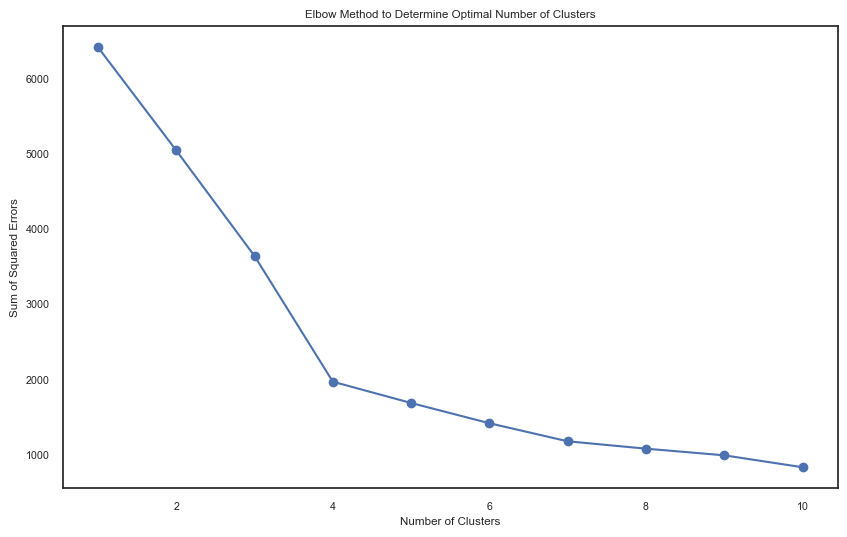

In [99]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')
plt.show()

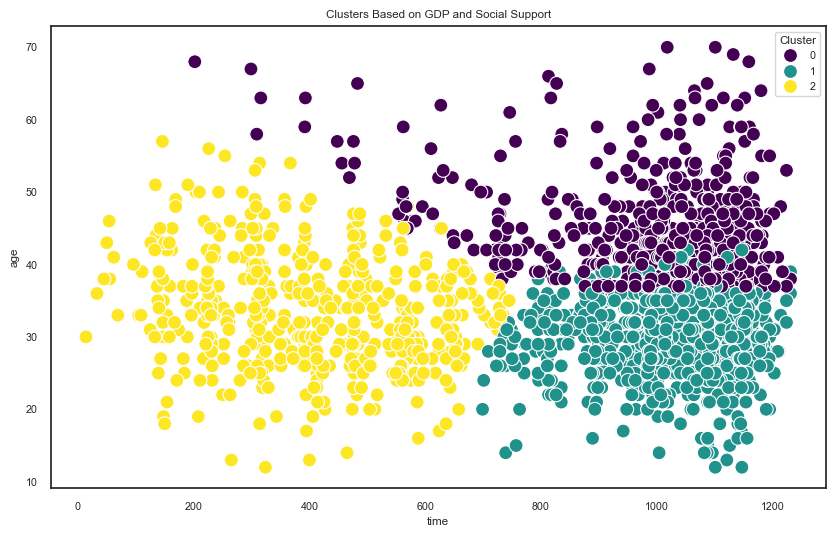

In [100]:
# Assuming the optimal number of clusters from the elbow plot is 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster labels to your DataFrame
df['Cluster'] = clusters

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time', y='age', data=df, hue='Cluster', palette='viridis', s=100)
plt.title('Clusters Based on GDP and Social Support')
plt.show()

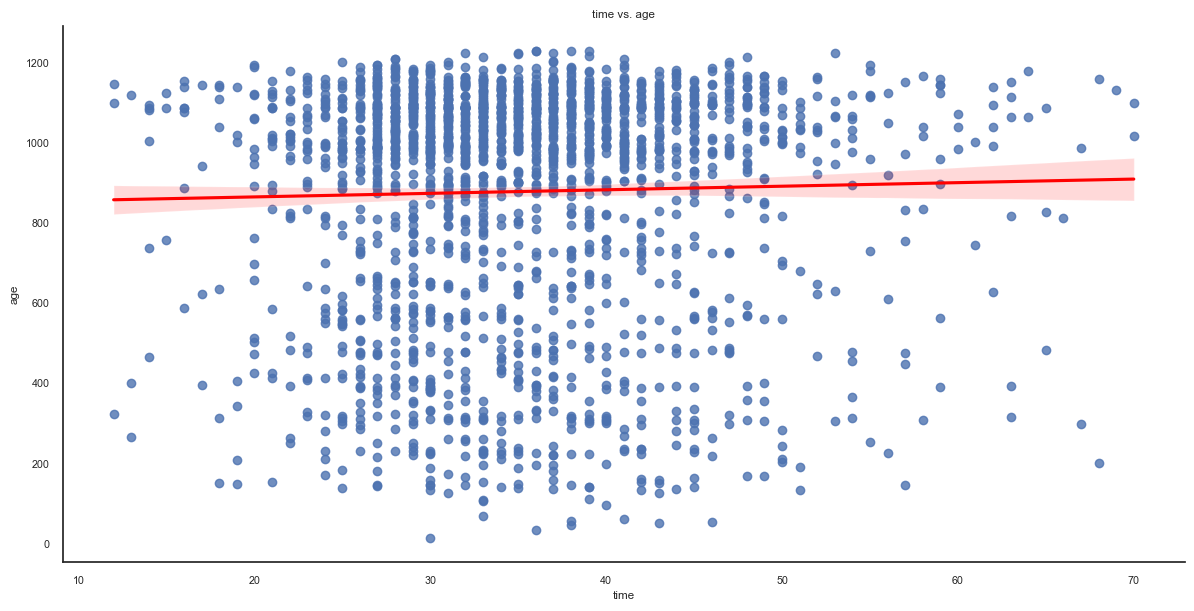

In [101]:
sns.lmplot(x='age', y='time', data=df, aspect=2, height=6, line_kws={'color': 'red'})
plt.title('time vs. age')
plt.xlabel('time')
plt.ylabel('age')
plt.show()

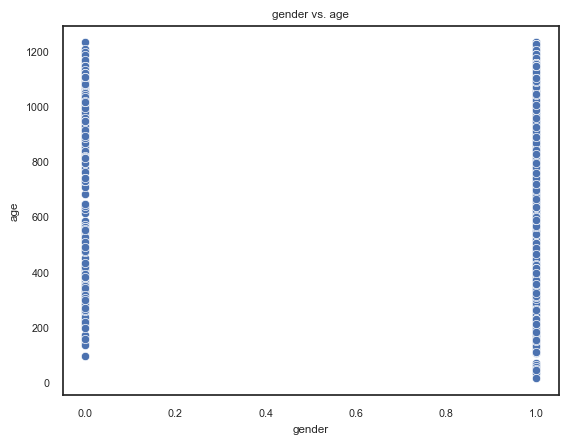

In [102]:
sns.scatterplot(x='gender', y='time', data=df)
plt.title('gender vs. age')
plt.xlabel('gender')
plt.ylabel('age')
plt.show()

In [105]:
# Define weights for each indicator based on their importance
weights = {
    'offtrt': 0.3,  
    'wtkg': 0.2,
    'time': 0.25, 
    'cd420': 0.15,
    'cd40': 0.1
}

# Ensure weights sum to 1 (normalized)
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}

In [106]:
# Apply weights and calculate weighted average for each row
df['Weighted Score'] = df.apply(lambda x: sum(x[col] * normalized_weights[col] for col in normalized_weights), axis=1)

          offtrt      wtkg      time     cd420      cd40
offtrt  1.000000 -0.003159 -0.475795 -0.196474 -0.145311
wtkg   -0.003159  1.000000  0.009225  0.020980  0.036401
time   -0.475795  0.009225  1.000000  0.350611  0.191436
cd420  -0.196474  0.020980  0.350611  1.000000  0.583578
cd40   -0.145311  0.036401  0.191436  0.583578  1.000000


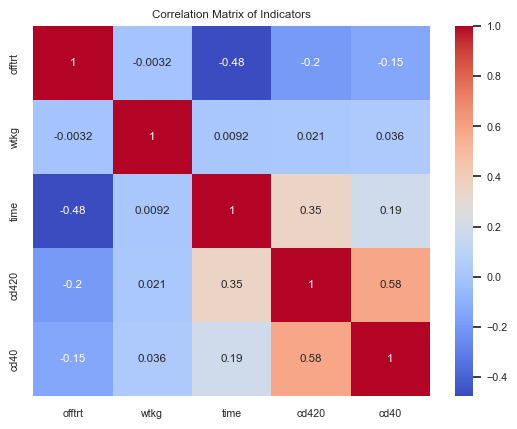

In [107]:
# Analyze correlations between indicators
correlation_matrix = df[list(weights.keys())].corr()
print(correlation_matrix)

# Visualize correlations for better understanding
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Indicators')
plt.show()

In [108]:
# Create a composite indicator from highly correlated variables
df['AIDS Composite'] = df[['cd40', 'cd420', 'time']].mean(axis=1)
# Update weights
updated_weights = {
    'AIDS Composite': 0.45,
    'strat': 0.25,
    'z30': 0.3
}

# Normalize updated weights
total_weight = sum(updated_weights.values())
normalized_weights = {k: v / total_weight for k, v in updated_weights.items()}

# Recalculate weighted average with updated weights
df['Updated Weighted Score'] = df.apply(lambda x: sum(x[col] * normalized_weights[col] for col in normalized_weights), axis=1)

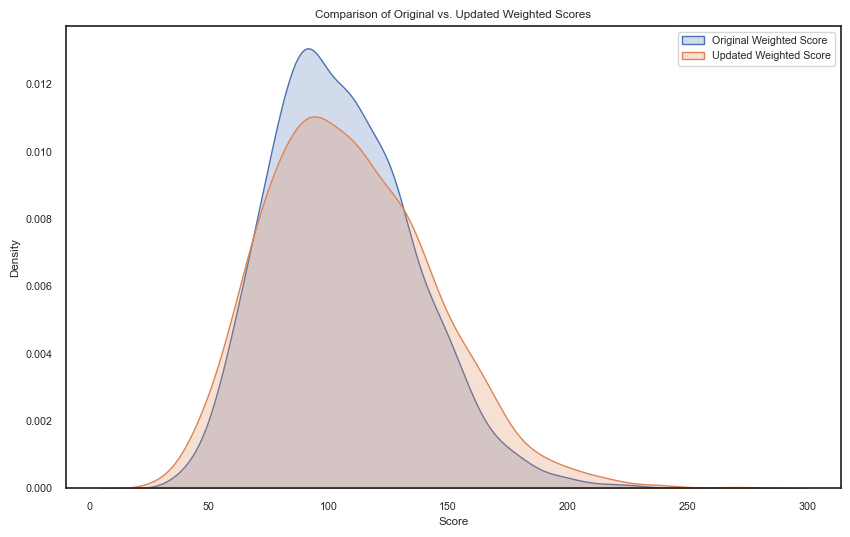

Original Score Statistics:
 count    2139.000000
mean      106.057799
std        30.376752
min        35.421073
25%        84.021309
50%       103.374117
75%       125.655842
max       246.271791
Name: Weighted Score, dtype: float64
Updated Score Statistics:
 count    2139.000000
mean      109.037926
std        35.119864
min        27.721652
25%        83.198192
50%       106.036442
75%       131.620481
max       276.527075
Name: Updated Weighted Score, dtype: float64


In [109]:
# Plotting old vs. new scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Weighted Score'], label='Original Weighted Score', fill=True)
sns.kdeplot(df['Updated Weighted Score'], label='Updated Weighted Score', fill=True)
plt.title('Comparison of Original vs. Updated Weighted Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Descriptive statistics
print("Original Score Statistics:\n", df['Weighted Score'].describe())
print("Updated Score Statistics:\n", df['Updated Weighted Score'].describe())

In [111]:
# List of factors to be normalized
factors = [
    'time', 'trt', 'age', 'wtkg', 'homo', 'drugs', 'karnof', 'cd40', 'cd420'
]

# Normalizing the factors using Min-Max Normalization
for factor in factors:
    normalized_name = factor + ' normalized'
    if normalized_name not in df.columns:  # Check if the column already exists
        df[normalized_name] = (df[factor] - df[factor].min()) / (df[factor].max() - df[factor].min())

# Assigning weights (adjust these as necessary)
weights = {
    'time': 0.1, 'trt': 0.2, 
    'age': 0.2, 'wtkg': 0.2, 
    'homo': 0.1, 'drugs': 0.05, 
    'karnof': 0.05,'cd40':0.05,'cd420':0.1
}

# Calculating the Composite Index
df['Composite Index'] = sum(df[weight_name] * weight for weight_name, weight in weights.items())

# Output the updated DataFrame
print(df[['infected', 'Composite Index']].head())

df.head(10)

   infected  Composite Index
0         0        92.363444
1         1        45.138629
2         0        66.832007
3         0        76.720709
4         0        79.131151


,infected,time,age,wtkg,preanti,cd40,cd420,cd80,cd820,hemo,...,time normalized,trt normalized,age normalized,wtkg normalized,homo normalized,drugs normalized,karnof normalized,cd40 normalized,cd420 normalized,Composite Index
0,0,0.767461,0.620690,89.8128,0,422,477,566,324,0,...,0.767461,0.666667,0.620690,0.456128,0.0,0.0,1.000000,0.351960,0.400000,92.363444
1,1,0.811832,0.844828,49.4424,895,162,218,392,564,0,...,0.811832,1.000000,0.844828,0.143032,0.0,0.0,0.666667,0.135113,0.157944,45.138629
2,0,0.778143,0.568966,88.4520,707,326,274,2063,1893,0,...,0.778143,1.000000,0.568966,0.445574,1.0,1.0,0.666667,0.271893,0.210280,66.832007
3,0,0.946590,0.603448,85.2768,1399,287,394,1590,966,0,...,0.946590,1.000000,0.603448,0.420948,1.0,0.0,1.000000,0.239366,0.322430,76.720709
4,0,0.884141,0.534483,66.6792,1352,504,353,870,782,0,...,0.884141,0.000000,0.534483,0.276713,1.0,0.0,1.000000,0.420350,0.284112,79.131151
5,0,0.958915,0.586207,88.9056,1181,235,339,860,1060,0,...,0.958915,0.333333,0.586207,0.449092,1.0,1.0,1.000000,0.195997,0.271028,68.994253
6,1,0.640920,0.327586,73.0296,930,244,225,708,699,0,...,0.640920,0.000000,0.327586,0.325964,1.0,0.0,1.000000,0.203503,0.164486,54.535529
7,0,0.774856,0.500000,66.2256,1329,401,366,889,720,0,...,0.774856,0.000000,0.500000,0.273195,1.0,1.0,1.000000,0.334445,0.296262,75.222606
8,1,0.151191,0.482759,82.5552,1074,214,107,652,131,0,...,0.151191,1.000000,0.482759,0.399841,1.0,0.0,0.666667,0.178482,0.054206,43.222711
9,1,0.142975,0.396552,78.0192,964,221,132,221,759,0,...,0.142975,0.000000,0.396552,0.364661,1.0,0.0,1.000000,0.184320,0.077570,45.047448


In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'your_data' is already loaded with your composite indicator
AIDS_report = pd.read_csv("C:\\Users\\jaygo\\OneDrive\\Desktop\\DAV-project\\dataset\\new dataset\\AIDS_Classification.csv")
AIDS_report.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [113]:
#checking how columns names are different. 
print("Columns in df:", df.columns)
print("Columns in AIDS_report:", AIDS_report.columns)

Columns in df: Index(['infected', 'time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80',
       'cd820', 'hemo', 'homo', 'drugs', 'oprior', 'z30', 'race', 'gender',
       'str2', 'symptom', 'treat', 'offtrt', 'trt', 'karnof', 'strat',
       'Cluster', 'Weighted Score', 'AIDS Composite', 'Updated Weighted Score',
       'time normalized', 'trt normalized', 'age normalized',
       'wtkg normalized', 'homo normalized', 'drugs normalized',
       'karnof normalized', 'cd40 normalized', 'cd420 normalized',
       'Composite Index'],
      dtype='object')
Columns in AIDS_report: Index(['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'preanti', 'race', 'gender', 'str2', 'strat',
       'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820',
       'infected'],
      dtype='object')


In [ ]:
columns_to_keep_df = [
    'Composite Index', 'time', 'trt', 'age', 'wtkg', 'homo', 'drugs', 'karnof', 'cd40', 'cd420'
]

# Define columns to keep for happiness_report
columns_to_keep_AIDS_report = [
    'Country', 'Region', 'Happiness Rank', 'Happiness Score', 
    'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
    'Freedom', 'Trust (Government Corruption)', 'Generosity'
]

# Filter the datasets
df_filtered = df[columns_to_keep_df]
AIDS_report_filtered = AIDS_report[columns_to_keep_AIDS_report]

# Assuming you want to merge on country name
df_filtered.rename(columns={'Country name': 'Country'}, inplace=True)

# Merge the datasets
merged_data = pd.merge(df_filtered, AIDS_report_filtered, on='Country', how='inner')

# Optionally, save the cleaned dataset to a new file
merged_data.to_csv('merged_dataset.csv', index=False)

merged_data.head(10)

In [ ]:
# Assuming your data is loaded into a DataFrame named df
# For example: df = pd.read_csv('your_merged_data.csv')

# Define the dependent variable (composite indicator)
Y = merged_data['Composite Index']

# Define independent variables
X = merged_data[['Economy (GDP per Capita)', 'Health (Life Expectancy)', 'Freedom',  'Trust (Government Corruption)']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
summary = model.summary()
print(summary)

In [114]:
# Define Y and X as before
Y = merged_data['Composite Index']
X = merged_data[['Economy (GDP per Capita)', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)']]
X = sm.add_constant(X)  # include intercept

# Fit the model
model = sm.OLS(Y, X).fit()

# Plotting the coefficients
coef = model.params[1:]  # excluding the constant term
coef.plot(kind='bar', color='green')
plt.title('Impact of Each Factor on Composite Index')
plt.xlabel('Factors')
plt.ylabel('Coefficient Value')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()

NameError: name 'merged_data' is not defined